In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


Importação de bibliotecas essenciais: numpy e pandas para tratamento de dados, matplotlib, seaborn e plotly para visualizações (estáticas e interativas)

In [2]:


# Download automático do dataset da Olist via kagglehub
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brazilian-ecommerce


In [3]:
df_orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')

df_orders_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')

df_orders_reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')

df_orders_products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')

df_orders_geo = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')

df_orders_sellers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')

df_orders_pay = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')

df_orders_customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')

df_orders_cat_transl = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')


Leitura de todos os arquivos .csv do projeto. Cada DataFrame representa um aspecto do negócio: pedidos, produtos, clientes, pagamentos, localização, etc.

# CONHECENDO O DATASET

In [4]:
def inspect_dataframe(df, name):
    print(f"\n--- Inspeção: {name} ---")
    print(f"Shape: {df.shape}")
    print("Colunas e Tipos:\n", df.dtypes)
    print("Valores Ausentes (Soma):\n", df.isnull().sum()[df.isnull().sum() > 0]) # Mostrar apenas colunas com NaNs
    print(f"Linhas Duplicadas: {df.duplicated().sum()}")

In [5]:
inspect_dataframe(df_orders, ' DF ORDERS')


--- Inspeção:  DF ORDERS ---
Shape: (99441, 8)
Colunas e Tipos:
 order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object
Valores Ausentes (Soma):
 order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64
Linhas Duplicadas: 0


Colunas de data estão como strings!

In [6]:
inspect_dataframe(df_orders_items, ' DF ORDERS ITEMS')


--- Inspeção:  DF ORDERS ITEMS ---
Shape: (112650, 7)
Colunas e Tipos:
 order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object
Valores Ausentes (Soma):
 Series([], dtype: int64)
Linhas Duplicadas: 0


In [7]:
inspect_dataframe(df_orders_customers, ' DF CUSTOMERS')


--- Inspeção:  DF CUSTOMERS ---
Shape: (99441, 5)
Colunas e Tipos:
 customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
Valores Ausentes (Soma):
 Series([], dtype: int64)
Linhas Duplicadas: 0


In [8]:
inspect_dataframe(df_orders_sellers, ' DF SELLERS')


--- Inspeção:  DF SELLERS ---
Shape: (3095, 4)
Colunas e Tipos:
 seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object
Valores Ausentes (Soma):
 Series([], dtype: int64)
Linhas Duplicadas: 0


In [9]:
inspect_dataframe(df_orders_reviews, ' DF REVIEWS')


--- Inspeção:  DF REVIEWS ---
Shape: (99224, 7)
Colunas e Tipos:
 review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object
Valores Ausentes (Soma):
 review_comment_title      87656
review_comment_message    58247
dtype: int64
Linhas Duplicadas: 0


In [10]:
inspect_dataframe(df_orders_products, 'DF ORDERS PRODUCTS')


--- Inspeção: DF ORDERS PRODUCTS ---
Shape: (32951, 9)
Colunas e Tipos:
 product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object
Valores Ausentes (Soma):
 product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
Linhas Duplicadas: 0


In [11]:
inspect_dataframe(df_orders_pay, ' DF ORDERS PAYMENTS')


--- Inspeção:  DF ORDERS PAYMENTS ---
Shape: (103886, 5)
Colunas e Tipos:
 order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object
Valores Ausentes (Soma):
 Series([], dtype: int64)
Linhas Duplicadas: 0


In [12]:
inspect_dataframe(df_orders_geo, ' DF ORDERS GEOLOCALICATION')


--- Inspeção:  DF ORDERS GEOLOCALICATION ---
Shape: (1000163, 5)
Colunas e Tipos:
 geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object
Valores Ausentes (Soma):
 Series([], dtype: int64)
Linhas Duplicadas: 261831


# Conversão de colunas de data para datetime

In [13]:
date_cols_orders = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                    'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols_orders:
    if col in df_orders.columns:
        df_orders[col] = pd.to_datetime(df_orders[col], errors='coerce')

 Converte colunas de timestamp para o formato datetime. Importante para fazer cálculos de datas e análises temporais.

In [14]:
df_orders.dtypes

,0
order_id,object
customer_id,object
order_status,object
order_purchase_timestamp,datetime64[ns]
order_approved_at,datetime64[ns]
order_delivered_carrier_date,datetime64[ns]
order_delivered_customer_date,datetime64[ns]
order_estimated_delivery_date,datetime64[ns]


In [15]:
date_cols_reviews = ['review_creation_date', 'review_answer_timestamp']
for col in date_cols_reviews:
    if col in df_orders_reviews.columns:
        df_orders_reviews[col] = pd.to_datetime(df_orders_reviews[col], errors='coerce')


In [16]:
df_orders_reviews.dtypes

,0
review_id,object
order_id,object
review_score,int64
review_comment_title,object
review_comment_message,object
review_creation_date,datetime64[ns]
review_answer_timestamp,datetime64[ns]


In [17]:
date_cols_items = ['shipping_limit_date']
for col in date_cols_items:
    if col in df_orders_items.columns:
        df_orders_items[col] = pd.to_datetime(df_orders_items[col], errors='coerce')

In [18]:
df_orders_items.dtypes

,0
order_id,object
order_item_id,int64
product_id,object
seller_id,object
shipping_limit_date,datetime64[ns]
price,float64
freight_value,float64


# Tratamento de valores ausentes

ORDERS PRODUCTS

In [19]:
df_orders_products.isnull().sum()


,0
product_id,0
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
product_weight_g,2
product_length_cm,2
product_height_cm,2
product_width_cm,2


In [20]:
df_orders_products['product_category_name'].fillna('desconhecida', inplace=True)

<ipython-input-20-c8219bdad869>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_orders_products['product_category_name'].fillna('desconhecida', inplace=True)


In [22]:
colunas = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty',
           'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

In [23]:
for coluna in colunas:
    mediana = df_orders_products[coluna].median()
    df_orders_products[coluna] = df_orders_products[coluna].fillna(mediana)

In [24]:
df_orders_products.isnull().sum()

,0
product_id,0
product_category_name,0
product_name_lenght,0
product_description_lenght,0
product_photos_qty,0
product_weight_g,0
product_length_cm,0
product_height_cm,0
product_width_cm,0


ORDERS REVIEWS

In [25]:
df_orders_reviews['review_comment_title'] = df_orders_reviews['review_comment_title'].fillna('sem_titulo', inplace=True)

<ipython-input-25-c24dcdae6b0b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_orders_reviews['review_comment_title'] = df_orders_reviews['review_comment_title'].fillna('sem_titulo', inplace=True)


In [26]:
df_orders_reviews['review_comment_message'] = df_orders_reviews['review_comment_message'].fillna('sem_mensagem', inplace=True)

<ipython-input-26-2b258c14ccab>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_orders_reviews['review_comment_message'] = df_orders_reviews['review_comment_message'].fillna('sem_mensagem', inplace=True)


# Criar um modelo relacional e conectar as tabelas

In [27]:
df_merged = pd.merge(df_orders, df_orders_customers, on='customer_id', how='left')

In [28]:
df_merged

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [29]:
df_merged = pd.merge(df_merged, df_orders_items, on='order_id', how='left')

In [30]:
df_merged.shape

(113425, 18)

In [31]:
df_merged = pd.merge(df_merged, df_orders_products, on='product_id', how='left')


In [32]:
df_merged.shape

(113425, 26)

In [33]:
df_merged = pd.merge(df_merged, df_orders_sellers, on='seller_id', how='left')


In [34]:
df_merged = pd.merge(df_merged, df_orders_cat_transl, on='product_category_name', how='left', suffixes=('', '_trans'))
df_merged['category_name'] = df_merged['product_category_name_english'].fillna(df_merged['product_category_name'])
df_merged.drop(columns=['product_category_name_english', 'product_category_name_trans'], errors='ignore', inplace=True)

In [35]:
df_merged.shape

(113425, 30)

In [36]:
df_merged = pd.merge(df_merged, df_orders_pay, on='order_id', how='left', suffixes=('', '_payment'))

In [37]:
df_merged = pd.merge(df_merged, df_orders_reviews, on='order_id', how='left', suffixes=('', '_review'))

In [38]:
df_merged.shape

(119143, 40)

In [39]:
df_analysis = df_merged.copy()

Remover linhas onde order_id é nulo (resultante de left joins onde não houve correspondência)


In [40]:
df_analysis.dropna(subset=['order_id', 'product_id', 'customer_id'], inplace=True)

In [41]:
df_orders_unique = df_analysis.drop_duplicates(subset=['order_id']).copy()

In [42]:
df_orders_unique

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,None,2017-10-11,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,None,None,2018-08-08,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,None,None,2018-08-18,2018-08-22 19:07:58
5,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,1.0,credit_card,1.0,72.20,359d03e676b3c069f62cadba8dd3f6e8,5.0,None,None,2017-12-03,2017-12-05 19:21:58
6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,1.0,credit_card,1.0,28.62,e50934924e227544ba8246aeb3770dd4,5.0,None,None,2018-02-17,2018-02-18 13:02:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119137,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,...,1.0,credit_card,3.0,85.08,e262b3f92d1ce917aa412a9406cf61a6,5.0,None,None,2017-03-22,2017-03-23 11:02:08
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,...,1.0,credit_card,3.0,195.00,29bb71b2760d0f876dfa178a76bc4734,4.0,None,None,2018-03-01,2018-03-02 17:50:01
119139,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,...,1.0,credit_card,5.0,271.01,371579771219f6db2d830d50805977bb,5.0,None,None,2017-09-22,2017-09-22 23:10:57
119140,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,...,1.0,credit_card,4.0,441.16,8ab6855b9fe9b812cd03a480a25058a1,2.0,None,None,2018-01-26,2018-01-27 09:16:56


# Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

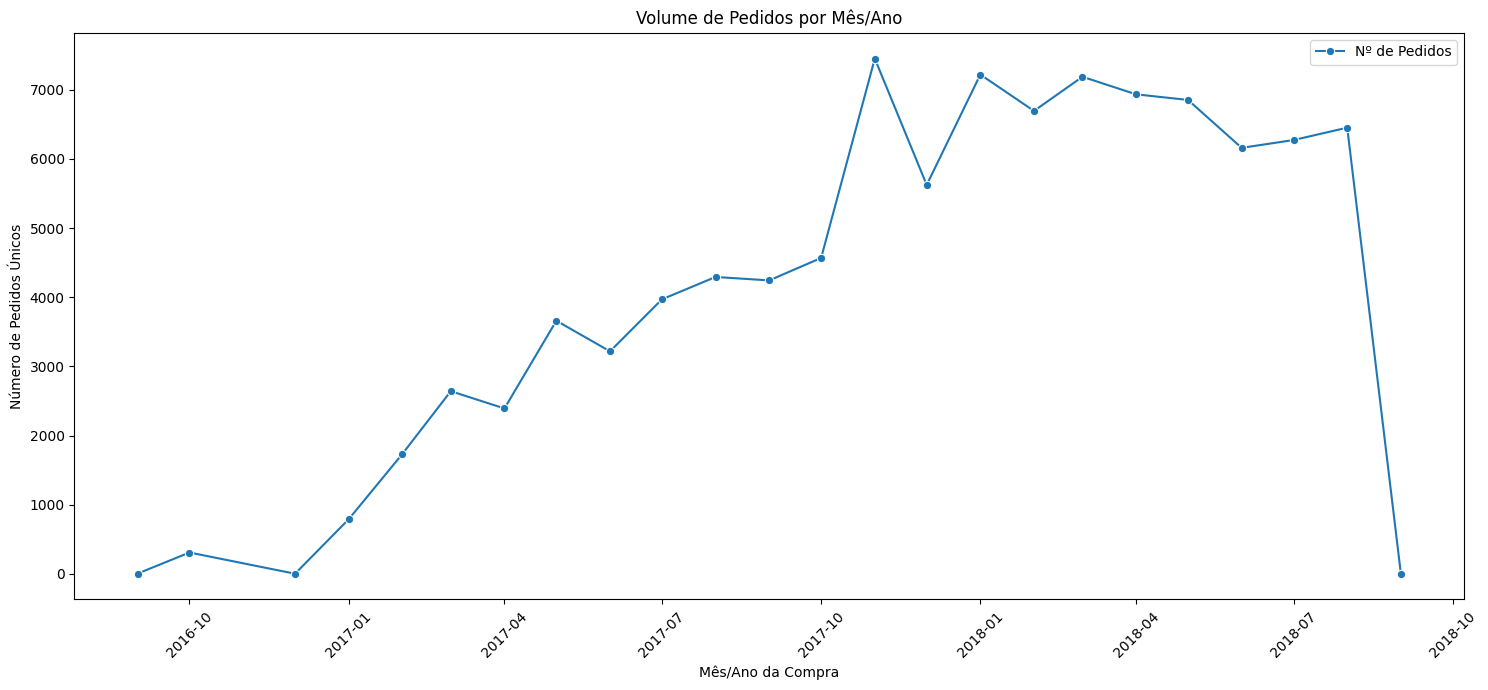

In [43]:
df_orders_unique['purchase_month_year'] = df_orders_unique['order_purchase_timestamp'].dt.to_period('M')
monthly_orders_volume = df_orders_unique.groupby('purchase_month_year')['order_id'].count().reset_index()
monthly_orders_volume['purchase_month_year'] = monthly_orders_volume['purchase_month_year'].dt.to_timestamp()

plt.figure(figsize=(15, 7))
sns.lineplot(x='purchase_month_year', y='order_id', data=monthly_orders_volume, marker='o', label='Nº de Pedidos')
plt.title('Volume de Pedidos por Mês/Ano')
plt.xlabel('Mês/Ano da Compra')
plt.ylabel('Número de Pedidos Únicos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


  Conclusão Sazonalidade: Observa-se um crescimento geral nas vendas entre 2016 e 2017. Pico ocorreu em novembro (Black Friday). Quedas são visíveis no início do ano.


# Qual a distribuição do tempo de entrega dos pedidos?


 Distribuição do tempo de entrega


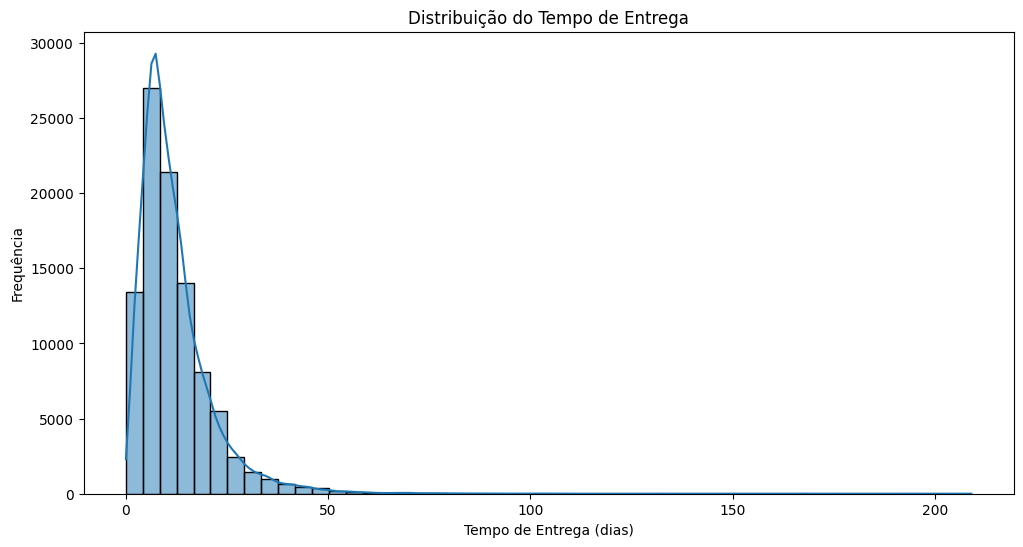

In [44]:
print("\n Distribuição do tempo de entrega")

delivered_orders_eda = df_orders_unique[df_orders_unique['order_status'] == 'delivered'].copy()
delivered_orders_eda.dropna(subset=['order_purchase_timestamp', 'order_delivered_customer_date'], inplace=True)
delivered_orders_eda['delivery_time_days'] = (delivered_orders_eda['order_delivered_customer_date'] - delivered_orders_eda['order_purchase_timestamp']).dt.days
delivered_orders_eda = delivered_orders_eda[delivered_orders_eda['delivery_time_days'] >= 0]

plt.figure(figsize=(12, 6))
sns.histplot(delivered_orders_eda['delivery_time_days'], bins=50, kde=True)
plt.title('Distribuição do Tempo de Entrega')
plt.xlabel('Tempo de Entrega (dias)')
plt.ylabel('Frequência')
plt.show()


In [45]:
print(f"   Estatísticas do Tempo de Entrega (dias):\n{delivered_orders_eda['delivery_time_days'].describe()}")


   Estatísticas do Tempo de Entrega (dias):
count    96470.000000
mean        12.093604
std          9.551380
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_time_days, dtype: float64


  Conclusão Tempo de Entrega:
  A média de entrega é de 12 dias, 75% das entregas ocorreram em até 15 dias. Porém, há bastante outliers indicados pela longa cauda, com um valor máximo de 209 dias para a entrega.


# Qual a relação entre o valor do frete e a distância de entrega?

<ipython-input-46-e1872ff6390c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_state', y='freight_value', data=avg_freight_by_customer_state, palette='viridis')


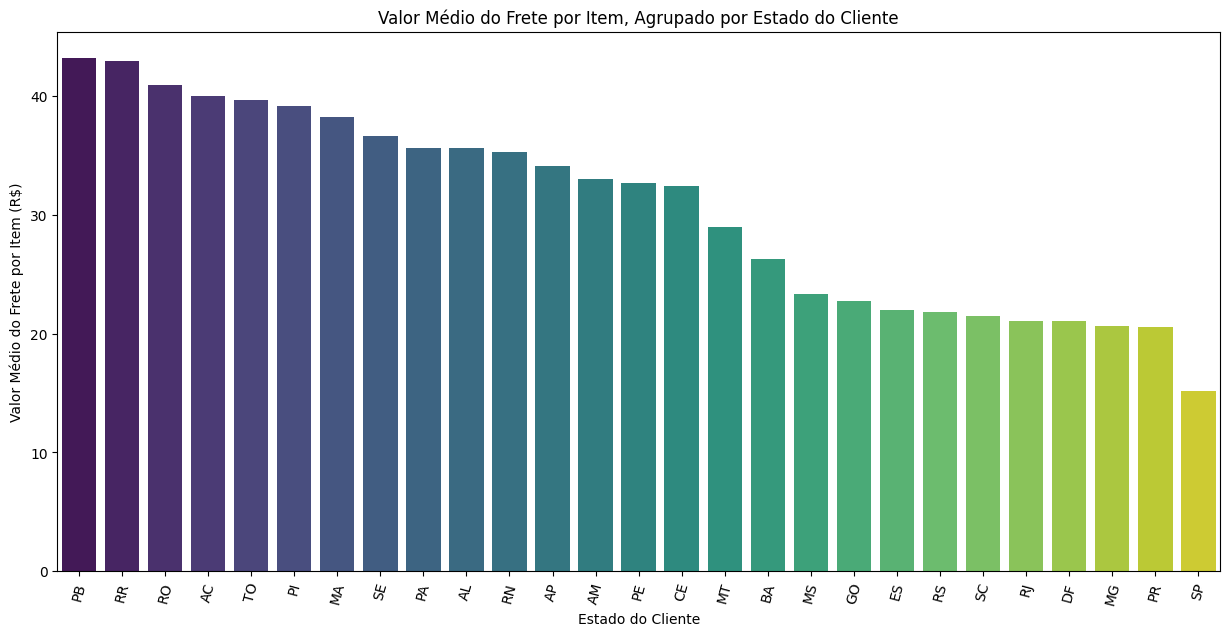

In [46]:
avg_freight_by_customer_state = df_analysis.groupby('customer_state')['freight_value'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(15, 7))
sns.barplot(x='customer_state', y='freight_value', data=avg_freight_by_customer_state, palette='viridis')
plt.title('Valor Médio do Frete por Item, Agrupado por Estado do Cliente')
plt.xlabel('Estado do Cliente')
plt.ylabel('Valor Médio do Frete por Item (R$)')
plt.xticks(rotation=75)
plt.show()

Conclusão Frete: Estados do Norte e Nordeste tendem a ter fretes mais caros, refletindo maiores distâncias dos centros de distribuição (geralmente Sudeste).

# Quais são as categorias de produtos mais vendidas em termos de faturamento?

<ipython-input-47-b2b4cf95410f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price', y='category_name', data=revenue_by_category_item, palette='magma')


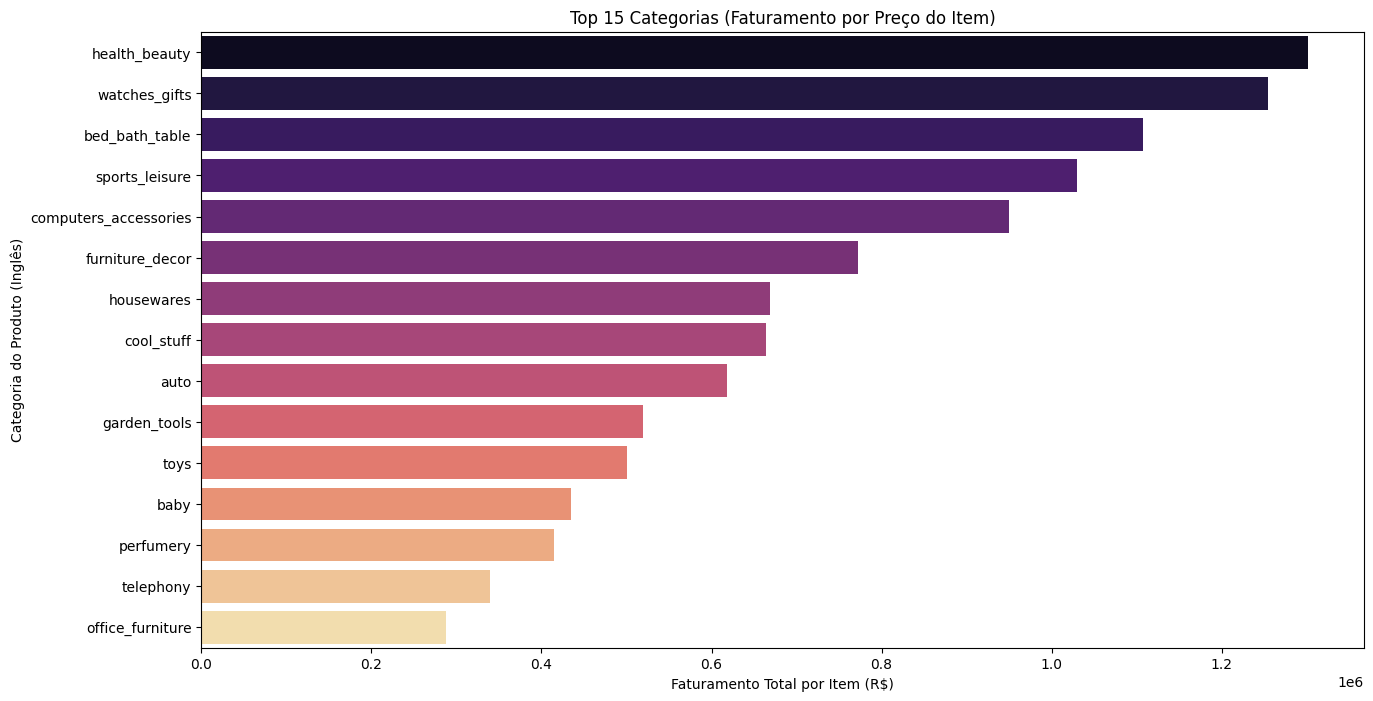

In [47]:
revenue_by_category_item = df_analysis.groupby('category_name')['price'].sum().sort_values(ascending=False).reset_index().head(15)
plt.figure(figsize=(15, 8))
sns.barplot(x='price', y='category_name', data=revenue_by_category_item, palette='magma')
plt.title('Top 15 Categorias (Faturamento por Preço do Item)')
plt.xlabel('Faturamento Total por Item (R$)')
plt.ylabel('Categoria do Produto (Inglês)')
plt.show()

Categorias como cama_mesa_banho, beleza_saude, esportes_lazer, informatica_acessorios e moveis_decoracao estão entre as de maior faturamento.

# Quais estados brasileiros possuem o maior valor médio de pedido?

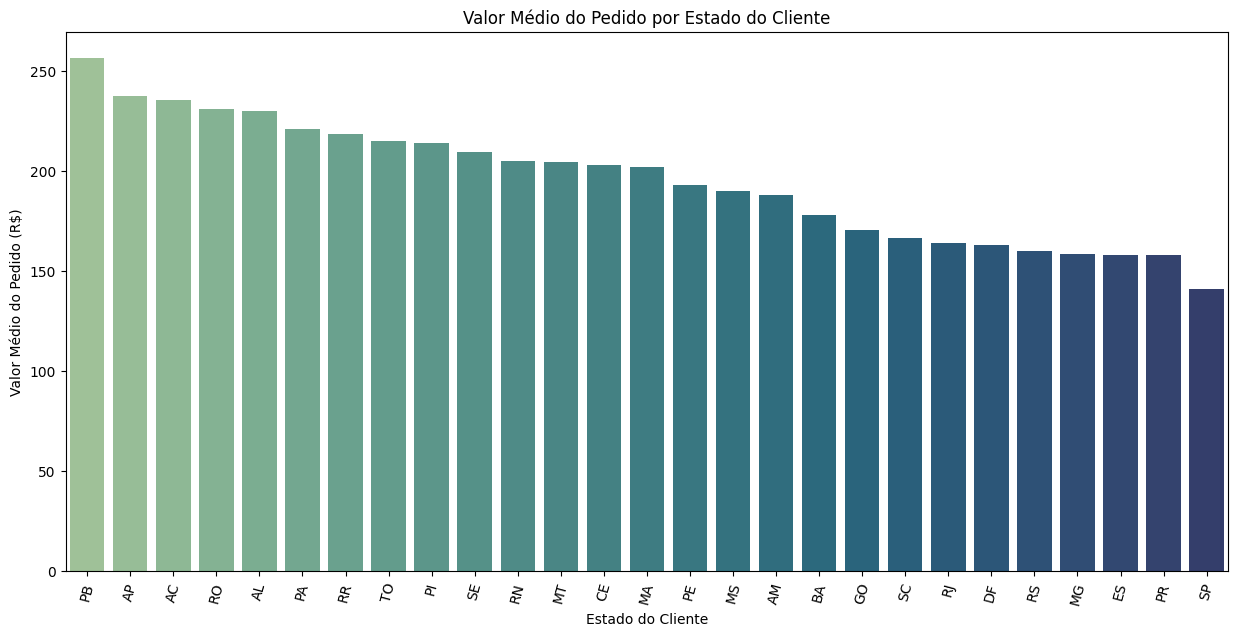

In [48]:
avg_order_value_by_state = (
    df_orders_unique
    .groupby('customer_state')['payment_value']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(15, 7))
sns.barplot(x='customer_state', y='payment_value', data=avg_order_value_by_state, palette='crest',  hue='customer_state', legend=False)
plt.title('Valor Médio do Pedido por Estado do Cliente')
plt.xlabel('Estado do Cliente')
plt.ylabel('Valor Médio do Pedido (R$)')
plt.xticks(rotation=75)
plt.show()




Pernambuco, Amapá, Acre e Rondônia são os estados de maior ticket médio

# Solução de Problemas de Negócio

In [49]:
customer_order_counts = df_orders_unique.groupby('customer_unique_id')['order_id'].nunique().reset_index(name='num_orders')
recurrent_customers = customer_order_counts[customer_order_counts['num_orders'] > 1]
num_recurrent_customers = recurrent_customers.shape[0]
total_unique_customers = customer_order_counts.shape[0]

In [50]:
if total_unique_customers > 0:
    recurrent_customer_rate = (num_recurrent_customers / total_unique_customers) * 100
    print(f"   Número total de clientes únicos: {total_unique_customers}")
    print(f"   Número de clientes recorrentes (mais de 1 pedido): {num_recurrent_customers}")
    print(f"   Taxa de clientes recorrentes: {recurrent_customer_rate:.2f}%")

   Número total de clientes únicos: 95420
   Número de clientes recorrentes (mais de 1 pedido): 2913
   Taxa de clientes recorrentes: 3.05%


# Predição de Atraso: Crie um modelo simples para prever se um pedido será entregue com atraso.

In [51]:
    df_analysis.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'], how='all', inplace=True)

    #  Calcular a diferença entre a data de entrega real e a data de entrega estimada
    df_analysis['delay'] = (df_analysis['order_delivered_customer_date'] - df_analysis['order_estimated_delivery_date']).dt.days

    # 4. Criar a variável 'is_delayed'
    df_analysis['is_delayed'] = df_analysis['delay'].apply(lambda x: 1 if x > 0 else 0)

    # Exibir algumas informações
    print(df_analysis[['order_id', 'order_estimated_delivery_date', 'order_delivered_customer_date', 'delay', 'is_delayed']].head())
    print("\nContagem de atrasos:")
    print(df_analysis['is_delayed'].value_counts())


                           order_id order_estimated_delivery_date  \
0  e481f51cbdc54678b7cc49136f2d6af7                    2017-10-18   
1  e481f51cbdc54678b7cc49136f2d6af7                    2017-10-18   
2  e481f51cbdc54678b7cc49136f2d6af7                    2017-10-18   
3  53cdb2fc8bc7dce0b6741e2150273451                    2018-08-13   
4  47770eb9100c2d0c44946d9cf07ec65d                    2018-09-04   

  order_delivered_customer_date  delay  is_delayed  
0           2017-10-10 21:25:13   -8.0           0  
1           2017-10-10 21:25:13   -8.0           0  
2           2017-10-10 21:25:13   -8.0           0  
3           2018-08-07 15:27:45   -6.0           0  
4           2018-08-17 18:06:29  -18.0           0  

Contagem de atrasos:
is_delayed
0    110751
1      7559
Name: count, dtype: int64


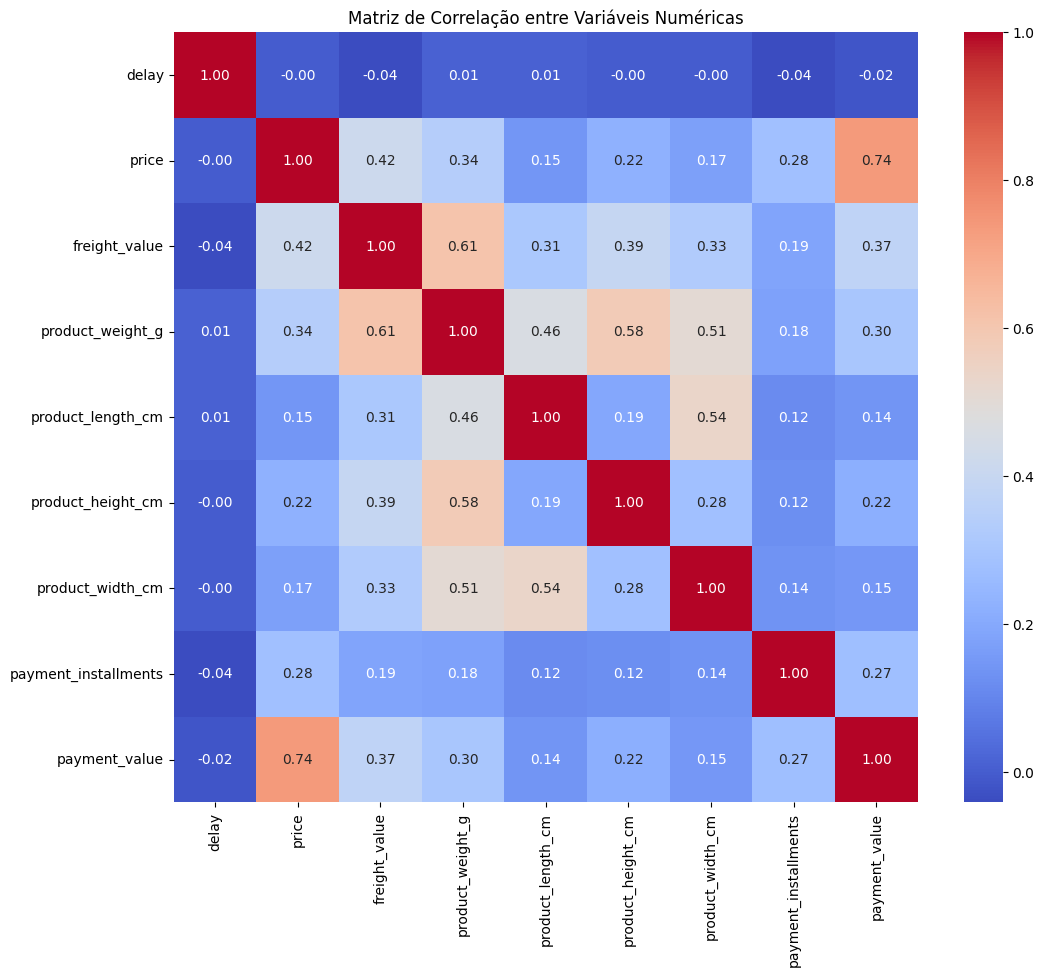

In [52]:
# Selecionar colunas numéricas relevantes
numeric_cols = [
    'delay', 'price', 'freight_value', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'payment_installments', 'payment_value'
]

# Calcular a matriz de correlação
corr_matrix = df_analysis[numeric_cols].corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

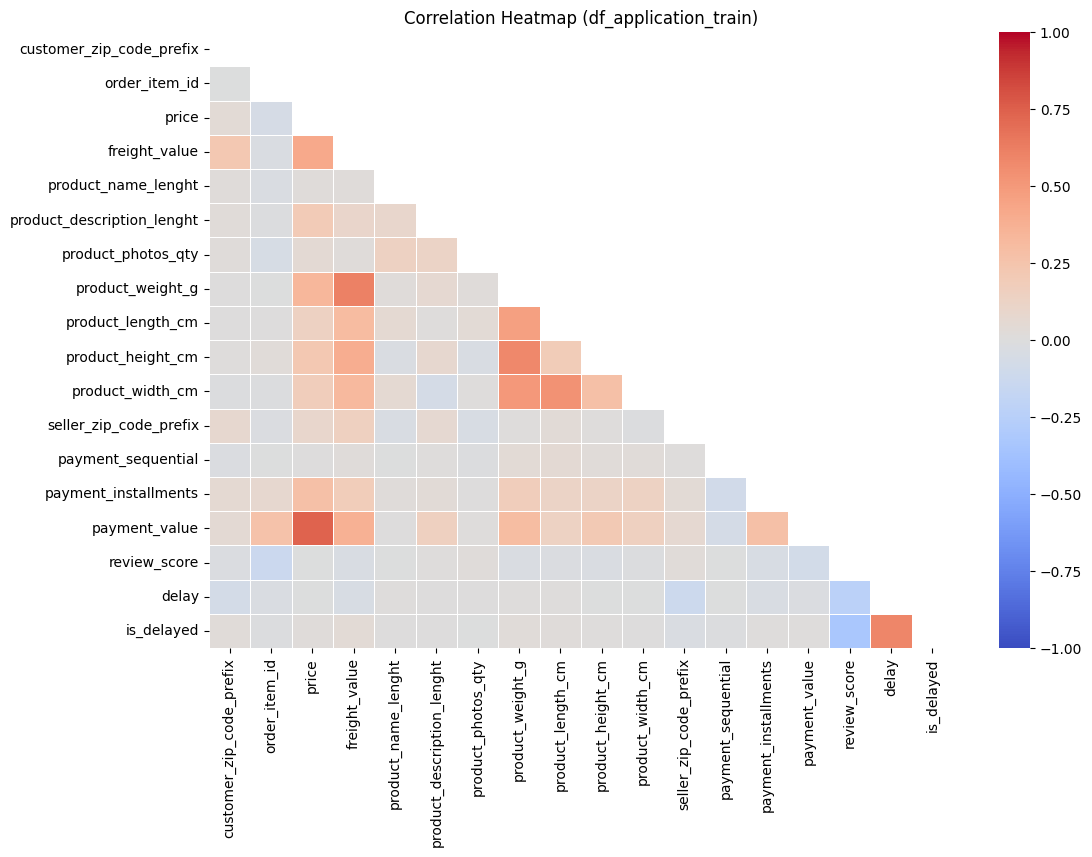

In [53]:
# Visualizar a matriz de correlação usando um mapa de calor
numeric_data = df_analysis.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=False,
    cmap="coolwarm",
    linewidths=0.5,
    vmin=-1, vmax=1
)

plt.title("Correlation Heatmap (df_application_train)")
plt.show()

Como a correlação com a dimensão is_delayed estava fraca foi realizado um novo merge com as categorias com possivelmente melhores correlações

In [54]:

df = df_orders.merge(df_orders_items, on='order_id', how='inner') \
              .merge(df_orders_products[['product_id', 'product_category_name']], on='product_id', how='left') \
              .merge(df_orders_customers[['customer_id', 'customer_state']], on='customer_id', how='left')

# Remover valores ausentes
df.dropna(subset=[
    'order_purchase_timestamp',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date'
], inplace=True)

# Converter datas
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

# Features temporais
df['tempo_envio'] = (df['shipping_limit_date'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df['tempo_entrega_estimado'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600

# Variável alvo
df['atrasado'] = df['order_delivered_customer_date'] > df['order_estimated_delivery_date']

# Codificação
df['product_category_name'] = df['product_category_name'].astype('category').cat.codes
df['customer_state'] = df['customer_state'].astype('category').cat.codes


<ipython-input-55-7e67d1570f95>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='atrasado', data=df, palette='colorblind')


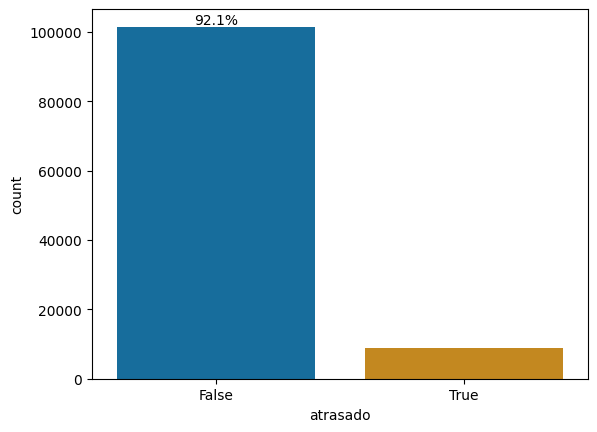

In [55]:
ax = sns.countplot(x='atrasado', data=df, palette='colorblind')

# obter a contagem total da coluna 'type'
total = df['atrasado'].count()

ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.1f}%')
plt.show()

Como a classe é desbalanceada, será utilizado SMOTE para que haja balanceamento

In [56]:

# Features finais
X = df[['tempo_envio', 'tempo_entrega_estimado', 'product_category_name', 'customer_state']]
y = df['atrasado']

# Aplicar SMOTE porque é desbalanceado
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Dividir e treinar
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliação
y_pred = model.predict(X_test)
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Matriz de Confusão:
 [[26995  3538]
 [ 2765 27591]]

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.91      0.88      0.90     30533
        True       0.89      0.91      0.90     30356

    accuracy                           0.90     60889
   macro avg       0.90      0.90      0.90     60889
weighted avg       0.90      0.90      0.90     60889



O modelo de classificação apresentou um desempenho sólido e equilibrado na distinção entre as classes True e False.

Desempenho Geral:

A acurácia total do modelo foi de 90%, o que significa que 9 em cada 10 previsões foram corretas.

As médias macro e ponderada das métricas de precision, recall e f1-score também ficaram em 0.90, indicando que o desempenho é consistente mesmo considerando o equilíbrio das classes.

Análise por Classe

Classe False (Negativo)

Precisão (0.91): Quando o modelo prevê "False", ele está certo em 91% dos casos.
Revocação (0.88): Entre todos os casos realmente "False", o modelo identificou corretamente 88%.
F1-score (0.90): Indica um bom equilíbrio entre precisão e recall para essa classe.

Classe True (Positivo)

Precisão (0.89): Quando o modelo prevê "True", ele acerta 89% das vezes.
Revocação (0.91): Ele consegue recuperar 91% dos casos realmente "True".
F1-score (0.90): Também mostra equilíbrio e desempenho consistente.

# SEGMENTAÇÃO DE CLIENTES COM K-MEANS


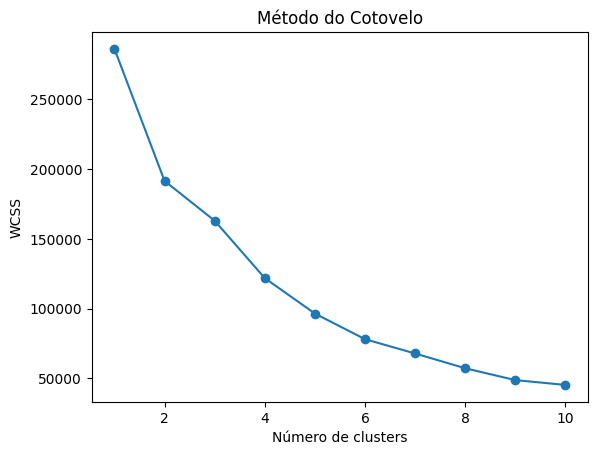

         num_orders    total_spent  total_items
cluster                                        
0          1.000000     173.767089     1.121056
1          2.114737     369.388491     2.545965
2          1.000000  109312.640000     8.000000
3          1.041367    2008.774862     5.055755


In [57]:

# Combinar dados necessários para segmentação de acordo com pagamento, itens e pedidos dos clientes
orders = pd.read_csv(path + '/olist_orders_dataset.csv')
order_items = pd.read_csv(path + '/olist_order_items_dataset.csv')
customers = pd.read_csv(path + '/olist_customers_dataset.csv')
payments = pd.read_csv(path + '/olist_order_payments_dataset.csv')

df = orders.merge(order_items, on='order_id') \
           .merge(customers, on='customer_id') \
           .merge(payments, on='order_id')

client_metrics = df.groupby('customer_unique_id').agg({
    'order_id': 'nunique',
    'payment_value': 'sum',
    'product_id': 'count'
}).rename(columns={
    'order_id': 'num_orders',
    'payment_value': 'total_spent',
    'product_id': 'total_items'
}).reset_index()

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(client_metrics[['num_orders', 'total_spent', 'total_items']])

# Método do cotovelo
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

# Aplicar KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
client_metrics['cluster'] = kmeans.fit_predict(X_scaled)

# Perfil dos clusters
numeric_cols = ['num_orders', 'total_spent', 'total_items']
cluster_profile = client_metrics.groupby('cluster')[numeric_cols].mean()
print(cluster_profile)



Estratégias de Marketing por Cluster

 Cluster 0 – Clientes Ocasional/Ticket Baixo

Perfil: Compram 1x, gastam pouco, compram poucos itens.
Ação:
Enviar cupons de desconto para segunda compra.
Incentivar com frete grátis em compras acima de certo valor.
Campanhas de recompra (“Faz tempo que você não compra!”).

 Cluster 1 – Clientes Recorrentes com Gasto Moderado

Perfil: Compram mais de 2 vezes, gastam moderadamente.
Ação:
Estratégia de fidelização: cashback, programa de pontos.
Personalizar ofertas com base em categorias que compram.
Incentivar assinaturas ou kits mensais.

Cluster 2 – Outlier (Cliente com Gasto Altíssimo)

Perfil: Comprou apenas uma vez, mas gastou mais de R$ 100 mil.
Ação:
Verificar se é erro ou compra corporativa.
Se válido: atendimento personalizado VIP.
Oferta de plano B2B ou atacado, com contato direto de vendas.

Cluster 3 – Compradores Esporádicos com Ticket Alto

Perfil: Compraram uma vez, mas gastaram muito e levaram muitos itens.
Ação:
Ação de recompra de alto valor.
Ofertas especiais para combos ou kits.
Enviar e-mails com produtos complementares ou upgrades.

#  ANÁLISE DE SATISFAÇÃO DOS CLIENTES


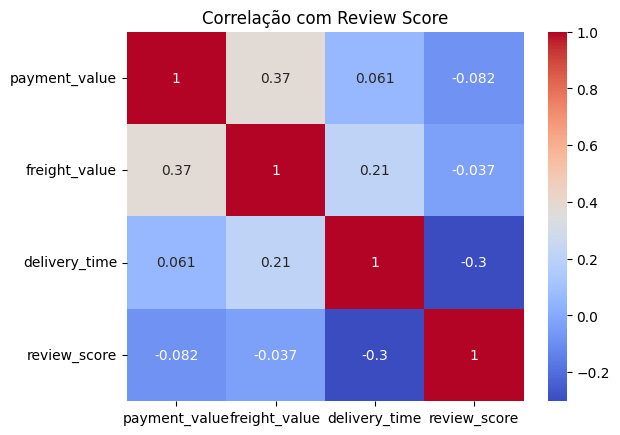

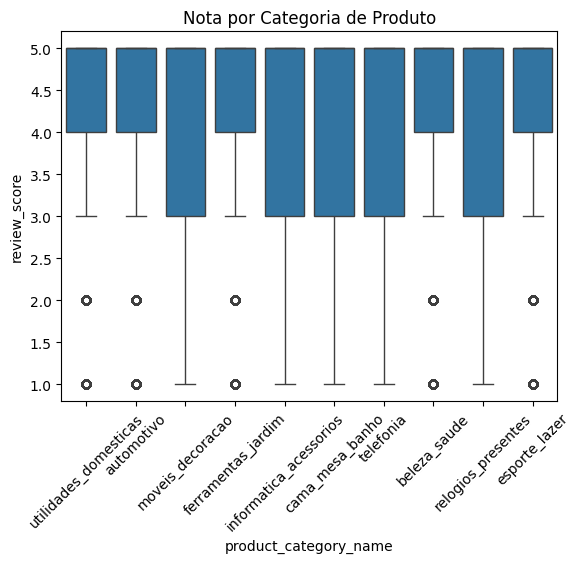

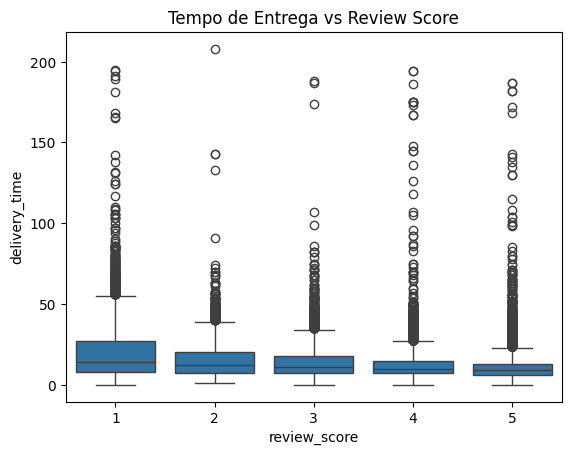

In [58]:
# Dataset para análise das reviews
reviews = pd.read_csv(path + '/olist_order_reviews_dataset.csv')
products = pd.read_csv(path + '/olist_products_dataset.csv')

df_full = df.merge(reviews[['order_id', 'review_score']], on='order_id', how='inner') \
            .merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

df_full['order_purchase_timestamp'] = pd.to_datetime(df_full['order_purchase_timestamp'])
df_full['order_delivered_customer_date'] = pd.to_datetime(df_full['order_delivered_customer_date'])
df_full['delivery_time'] = (df_full['order_delivered_customer_date'] - df_full['order_purchase_timestamp']).dt.days

# Correlação
corr_vars = ['payment_value', 'freight_value', 'delivery_time']
corr = df_full[corr_vars + ['review_score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlação com Review Score')
plt.show()

# Nota por categoria
top_cats = df_full['product_category_name'].value_counts().nlargest(10).index
sns.boxplot(data=df_full[df_full['product_category_name'].isin(top_cats)],
            x='product_category_name', y='review_score')
plt.xticks(rotation=45)
plt.title('Nota por Categoria de Produto')
plt.show()

# Tempo de entrega vs review
sns.boxplot(x='review_score', y='delivery_time', data=df_full)
plt.title('Tempo de Entrega vs Review Score')
plt.show()


1. Matriz de Correlação

  Variável mais correlacionada negativamente com a nota (review_score) é o tempo de entrega (delivery_time), com correlação -0.30.
  Ou seja, quanto maior o tempo de entrega, menor tende a ser a nota dada pelo cliente.
payment_value e freight_value têm baixa correlação positiva ou quase nula com a nota. Eles não influenciam significativamente a satisfação.

2. Boxplot de review_score por product_category_name

  A distribuição de notas é bem semelhante entre categorias.
Quase todas têm mediana acima de 4, com outliers nas notas mais baixas (1 e 2).
Não há uma categoria com notas drasticamente piores, mas móveis e decoração, cama/mesa/banho e telefonia parecem ter uma maior dispersão e mais outliers.

3. Boxplot delivery_time vs review_score

  Confirma a correlação negativa:
Clientes que deram nota 5 tendem a ter menor tempo de entrega.
Notas 1 e 2 estão associadas a tempos de entrega mais altos e dispersos.
A mediana do tempo de entrega diminui à medida que a nota aumenta.


Conclusões práticas:

O maior fator de insatisfação parece ser o tempo de entrega.
Investir em logística pode melhorar diretamente o review_score.
Categorias com maior dispersão nas notas merecem atenção específica (ex: móveis/decoração e telefonia), pois podem ter problemas além da entrega, como qualidade ou descrição do produto.
Valores pagos (frete ou total) não influenciam tanto na nota. O cliente não penaliza a loja por preço, desde que receba rápido e bem.

In [59]:

# Agrupar por data, estado e categoria
df_full['order_purchase_timestamp'] = pd.to_datetime(df_full['order_purchase_timestamp'])
df_full['order_date'] = df_full['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

df_sales = df_full.groupby(['order_date', 'customer_state', 'product_category_name'])['payment_value'].sum().reset_index()

# Gráfico interativo
fig = px.line(df_sales,
              x='order_date',
              y='payment_value',
              color='product_category_name',
              facet_col='customer_state',
              facet_col_wrap=4,
              title='Evolução das Vendas ao Longo do Tempo',
              labels={'payment_value': 'Total de Vendas', 'order_date': 'Data'})
fig.update_layout(height=1000)
fig.show()


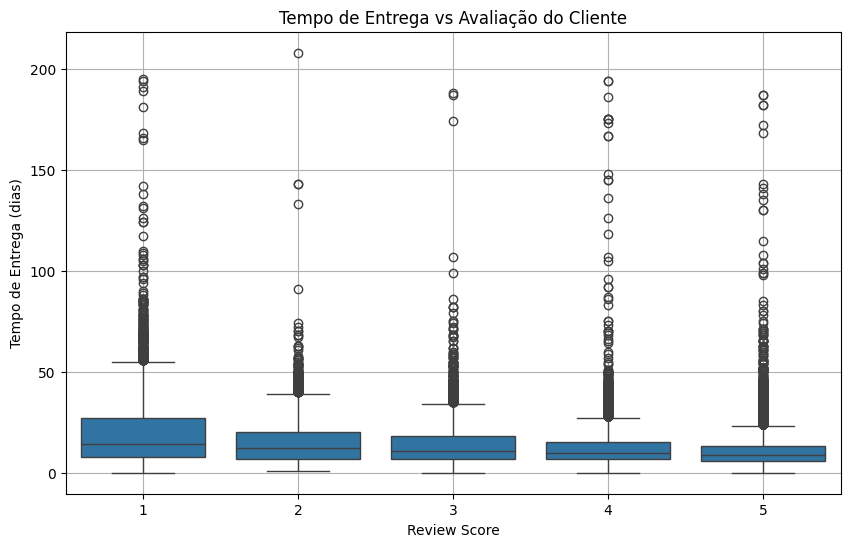

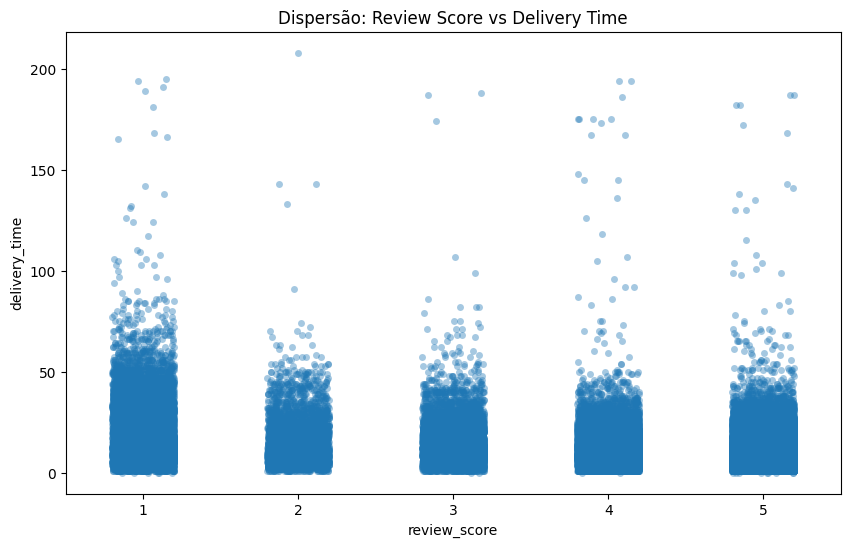

In [60]:

# Boxplot tempo de entrega vs review
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='delivery_time', data=df_full)
plt.title('Tempo de Entrega vs Avaliação do Cliente')
plt.xlabel('Review Score')
plt.ylabel('Tempo de Entrega (dias)')
plt.grid(True)
plt.show()

# Gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.stripplot(x='review_score', y='delivery_time', data=df_full, jitter=0.2, alpha=0.4)
plt.title('Dispersão: Review Score vs Delivery Time')
plt.show()


In [61]:
df_sellers = df_full.groupby('seller_id').agg({
    'order_id': 'count',
    'review_score': 'mean',
    'delivery_time': 'mean',
    'payment_value': 'sum'
}).reset_index().rename(columns={
    'order_id': 'num_orders',
    'review_score': 'avg_review_score',
    'delivery_time': 'avg_delivery_time',
    'payment_value': 'total_revenue'
})

# Top 20 vendedores por volume de vendas
top_sellers = df_sellers.sort_values('num_orders', ascending=False).head(20)

# Gráfico
fig = px.bar(top_sellers,
             x='seller_id',
             y='num_orders',
             hover_data=['avg_review_score', 'avg_delivery_time', 'total_revenue'],
             title='Top 20 Vendedores por Volume de Pedidos')
fig.show()
